In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from matplotlib import gridspec
import math
from scipy.optimize import curve_fit

Data_Folder = "Test"
Data_Folder_2 = "Test_2"
Test_Files = glob.glob(os.path.join(Data_Folder, "*", "test.txt"))[2:]
Test_Files_2 = glob.glob(os.path.join(Data_Folder_2, "*", "ECRAM_Group1_20250610.txt"))

In [2]:
def Load_Files(file_locations, start, end = None):
    """
    start: <int> OR <array>, start index of desired range or array of desired indexes
    end: <int> end index of desired range (not included)
    """
    if type(start) == int:
        df =  pd.read_csv(file_locations[start], sep="\t", header = 9)

        if type(end) == int:
            for file in file_locations[start+1:end]:
                df = pd.concat([df, pd.read_csv(file, sep="\t", header = 9)], ignore_index=True)
    else:
        df = pd.read_csv(file_locations[start[0]], sep="\t", header = 9)
        for index in start[1:]:
            df = pd.concat([df, pd.read_csv(file_locations[index], sep="\t", header = 9)], ignore_index=True)

    return df

df = Load_Files(Test_Files_2, 0)

In [3]:
def Group_Gate_Voltage(df):

    # Step 1: Create a sign label
    df['label'] = df['Gate Voltage (V)'].apply(lambda x: 'positive' if x > 0.001 else 'zero' if -0.001 < x < 0.001 else 'negative')
    # Step 2: Mark boundaries between different labels
    df['group'] = (df['label'] != df['label'].shift()).cumsum()
    df['FileNr'] = (df['Time (s)'] == 0).cumsum()
    df['Prev-V'] = ''
    # Step 3: Post-process zero groups
    group_labels = df.groupby('group')['label'].first()
    group_voltages = df.groupby('group')['Gate Voltage (V)'].first()
    # Create mapping: group_id → new label
    new_labels = {}
    new_voltage = {}
    
    for (group_id, label), (_, V) in zip(group_labels.items(), group_voltages.items()):
        if label == 'zero':
            prev_label = group_labels.get(group_id - 1, None)
            prev_voltage = group_voltages.get(group_id - 1, None)
            new_voltage[group_id] = prev_voltage
            if prev_label == 'positive':
                new_labels[group_id] = 'zero-p'
                
            elif prev_label == 'negative':
                new_labels[group_id] = 'zero-n'
            else:
                new_labels[group_id] = 'zero'  # fallback
        else:
            new_labels[group_id] = label
    
    # Apply new labels
    df['label'] = df['group'].map(new_labels)
    df['Prev-V'] = df['group'].map(new_voltage)

    
    df = df.drop(df[df['Time (s)']<0.001].index)
    return df

df = Group_Gate_Voltage(df)

def Disp_Group(df, limit=np.inf):
    grouped = df.groupby(['group', 'label'])
    for (group_id, label), group_df in grouped:
        print(f"Group {group_id} ({label}):")
        print(group_df)
        print()
        if group_id > limit:
            break
#Disp_Group(df, 0)

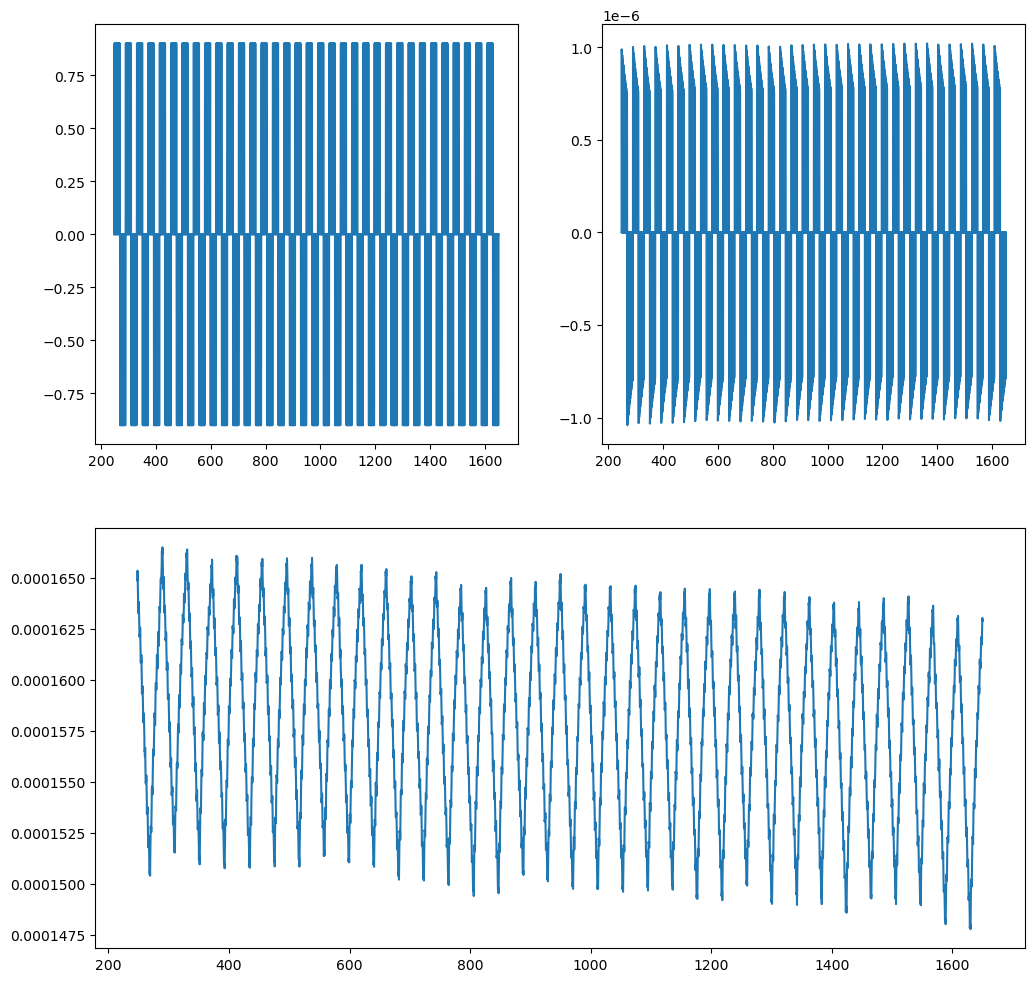

In [4]:
def df_Plot(df, y_range=(None,None), x_range=(None,None)):
    fig = plt.figure(
    figsize = (12, 12))
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 0:2])
    grouped = df.groupby(['FileNr'])
    for group_id, group_df in grouped:
        ax1.plot(group_df["Time (s)"], group_df['Gate Voltage (V)'])
        ax2.plot(group_df["Time (s)"], group_df['Gate Current (A)'])
        ax3.plot(group_df["Time (s)"], group_df['Drain Current (A)'])
    ax3.set_ylim(ymin=y_range[0], ymax=y_range[1])
    ax3.set_xlim(xmin=x_range[0], xmax=x_range[1])
df_Plot(df)

In [5]:
def Reset_Time(df):
    grouped = df.groupby(['group', 'label'])
    for (group_id, label), group in grouped:
        df.loc[df['group']==group_id, 'Time (s)'] = group['Time (s)']-group['Time (s)'].iloc[0]
    return df

df = Reset_Time(df)
Disp_Group(df, 0)

Group 1 (zero):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A) label  \
0       0.0         -0.000019           0.000165      1.982450e-11  zero   

   group  FileNr  Prev-V  
0      1       0     NaN  



In [6]:
def Lin_Fit_2(df, label):
    def lin(x,a,b):
        return a*x + b

    filled_markers = ('.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*', '0.45': 'd'}
    fit_a = []
    fit_b = []
    voltage = []
    x = []
    
    for _, group_df in df[df['label']==label].groupby('group'):
        if group_df.shape[0] > 1:
            #group_df['Time (s)'] = group_df['Time (s)']
            #group_df = group_df.iloc[1:]
            #a, b = np.polyfit(group_df['Drain Current (A)'].iloc[1:], group_df['Time (s)'].iloc[1:], 1)
            popt, pcov = curve_fit(lin, group_df['Time (s)'].iloc[1:], group_df['Drain Current (A)'].iloc[1:])
            
            x_i = group_df['Drain Current (A)'].iloc[1]
            fit_a.append(popt[0])
            fit_b.append(popt[1])
            x.append(x_i)
            if label in ['positive', 'negative']:
                voltage.append(str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2)))
            else:
                voltage.append(str(round(abs(float(group_df['Prev-V'].iloc[0])), 2)))
    markerstyle = np.vectorize(markerstyles.get)(voltage)
    return fit_a, fit_b, x, markerstyle

    

def Gate_Fit(df, label):
    fit_a, fit_b, x, markerstyle = Lin_Fit_2(df, label)
    fit_df = pd.DataFrame(data={'a':fit_a, 'b':fit_b, 'x':x, 'style':markerstyle})
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    grouped = fit_df.groupby('style')
    
    
    fig = plt.figure(figsize=(5, 5), tight_layout = True)
    for _, group_df in grouped:
        style = group_df['style'].values[0]
        group_df = group_df.sort_values(by=['x'])
        popt, pcov = curve_fit(func,group_df['x'],group_df['a'])
        print(style)
        print("a, b, c", popt)
        print("STD Errors", np.sqrt(np.diag(pcov)))
        y_pred = func(group_df['x'],*popt)
        
        
        plt.scatter(group_df['x'], group_df['a'], marker = style, color = colors[label])
        #plt.plot(x_l, y_a)
        plt.plot(group_df['x'], y_pred)
        #plt.show()
    plt.show()
    


In [29]:
def df_Plot(df, y_range=(None,None), x_range=(None,None)):
    fig = plt.figure(figsize = (12, 12))
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 0:2])
    grouped = df.groupby(['FileNr'])
    for group_id, group_df in grouped:
        ax1.plot(group_df["Time (s)"], group_df['Gate Voltage (V)'])
        ax2.plot(group_df["Time (s)"], group_df['Gate Current (A)'])
        ax3.plot(group_df["Time (s)"], group_df['Drain Current (A)']*1000)
    fig.tight_layout(pad=2)
    ax3.set_ylim(ymin=y_range[0], ymax=y_range[1])
    ax1.set_xlim(xmin=x_range[0], xmax=x_range[1])
    ax2.set_xlim(xmin=x_range[0], xmax=x_range[1])
    ax3.set_xlim(xmin=x_range[0], xmax=x_range[1])

    ax1.grid()
    ax1.set_title("Applied Voltage Pulses")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Gate Voltage (V)")

    ax2.grid()
    ax2.set_title("Measured Current of Applied Pulses")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Gate Current (A)")

    ax3.grid()
    ax3.set_title("Measured Source-Drain Current")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Source-Drain Current (mA)")
    fig.legend(['±0.9 V Pulse for 1 s', '±0.45 V Pulse for 2s', '±0.3 V Pulse for 3s' ], loc='upper right', bbox_to_anchor=(0.97, 0.96))
    
    
    plt.savefig("Measurement.pdf")

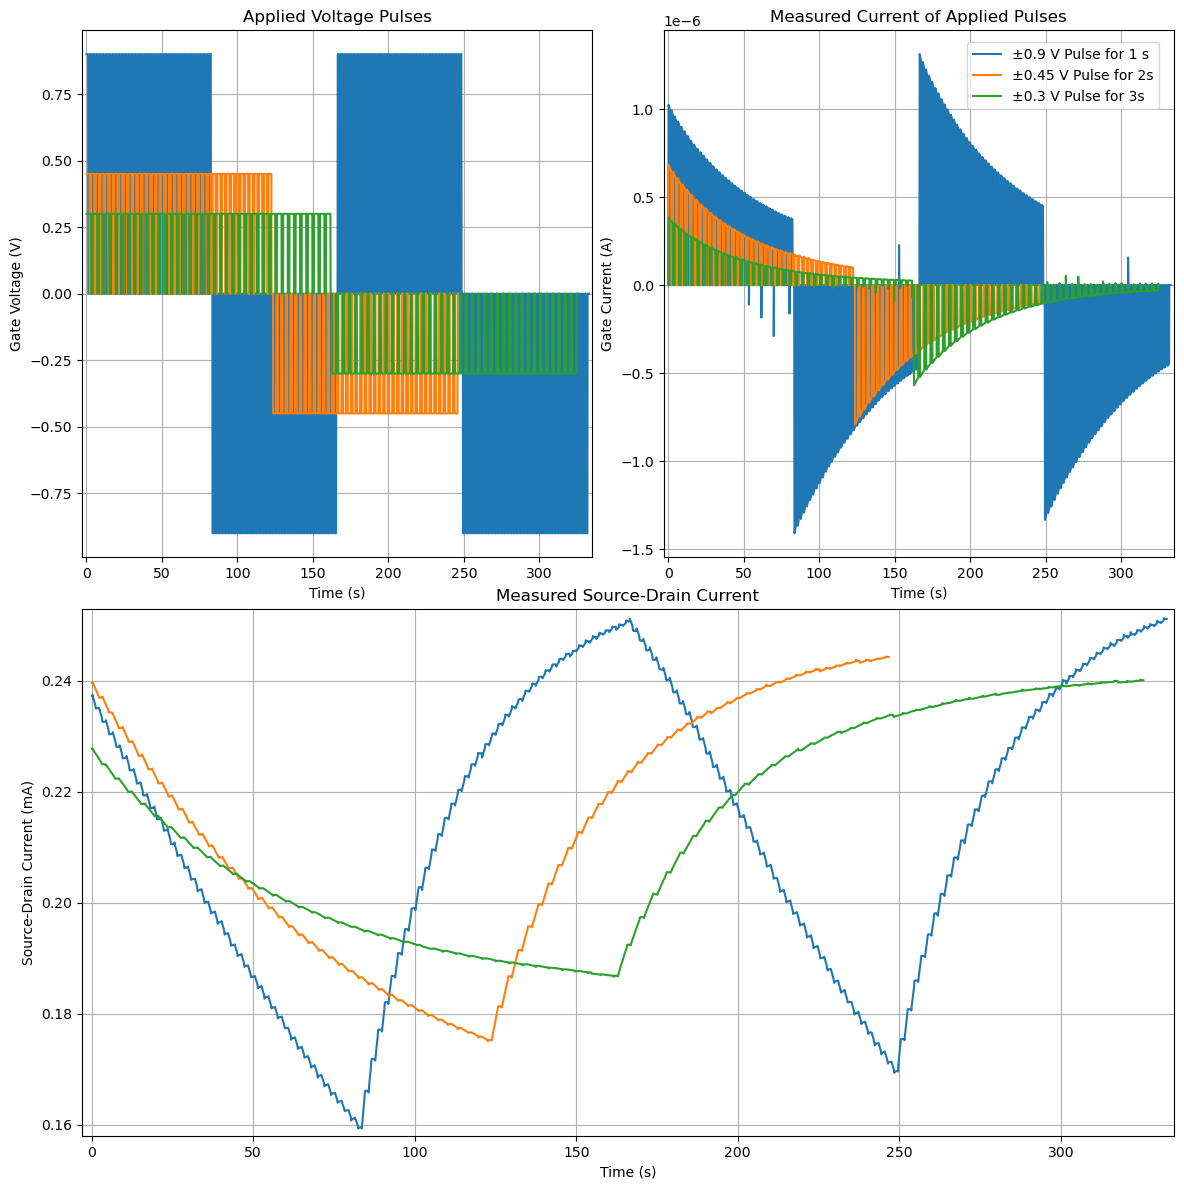

In [30]:
df = Load_Files(Test_Files_2, [3, 7, 6])
df = Group_Gate_Voltage(df)
df_Plot(df, y_range=(0.158,0.253), x_range=(-3,335))

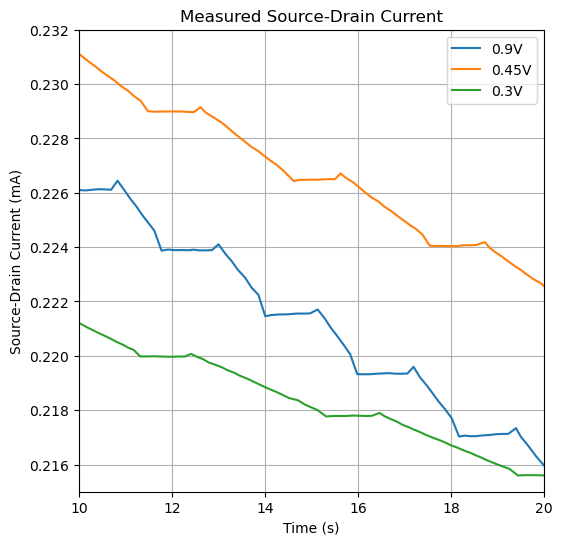

In [31]:
grouped = df.groupby(['FileNr'])
fig = plt.figure(figsize = (6, 6))
for group_id, group_df in grouped:
    
    plt.plot(group_df["Time (s)"], group_df['Drain Current (A)']*1000)
    plt.ylim(ymin=0.215, ymax=0.232)
    plt.xlim(xmin=10, xmax=20)
    plt.grid()
    plt.title("Measured Source-Drain Current")
    plt.xlabel("Time (s)")
    plt.ylabel("Source-Drain Current (mA)")
    plt.legend(["0.9V", "0.45V", "0.3V"])
    plt.savefig("DrainCurrentZoom.pdf")

In [32]:
from scipy.stats import linregress
import numpy as np
import pandas as pd


def summarize_hardware_metrics(df):

    results = []

    for label, df_label in df.groupby("label"):
        for group_id, df_group in df_label.groupby("group"):
            if len(df_group) < 5:
                continue
            slope, intercept, _, _, _ = linregress(df_group['Time (s)'], df_group['Drain Current (A)'])
            results.append({
                'label': label,
                'group': group_id,
                'slope': slope,
                'intercept': intercept,
                'mean_current': df_group['Drain Current (A)'].mean(),
                'std_current': df_group['Drain Current (A)'].std()
            })


    result_df = pd.DataFrame(results)

    # ON/OFF ratio (simplified): max abs mean current
    on_current = result_df[result_df['label'] == 'positive']['mean_current'].abs().max()
    off_current = result_df[result_df['label'] == 'zero-p']['mean_current'].abs().min()
    on_off_ratio = on_current / off_current if off_current != 0 else np.inf

    # Write noise estimate: std of residuals in active segments
    write_noise_est = result_df[result_df['label'].isin(['positive', 'negative'])]['std_current'].mean()

    # Read noise estimate: std in zero regions
    read_noise_est = result_df[result_df['label'].str.startswith('zero')]['std_current'].mean()

    # Linearity proxy: standard deviation of slopes in each label
    slope_var = result_df.groupby('label')['slope'].std().to_dict()

    # Symmetry: difference in avg slope between positive and negative
    mean_pos = result_df[result_df['label'] == 'positive']['slope'].mean()
    mean_neg = result_df[result_df['label'] == 'negative']['slope'].mean()
    symmetry_error = abs(mean_pos + mean_neg)  # should be close to 0 if symmetric

    print("\n=== Hardware Metrics Summary ===")
    print(f"ON/OFF ratio:        {on_off_ratio:.2f}")
    print(f"Write noise std:     {write_noise_est:.2e}")
    print(f"Read noise std:      {read_noise_est:.2e}")
    print(f"Linearity (std dev of slope): {slope_var}")
    print(f"Symmetry error:      {symmetry_error:.2e}")
    print("================================\n")

    return {
        "on_off_ratio": on_off_ratio,
        "write_noise_std": write_noise_est,
        "read_noise_std": read_noise_est,
        "linearity_stddev": slope_var,
        "symmetry_error": symmetry_error,
        "full_slope_df": result_df
    }


metrics = summarize_hardware_metrics(df)


=== Hardware Metrics Summary ===
ON/OFF ratio:        1.57
Write noise std:     5.16e-07
Read noise std:      4.31e-08
Linearity (std dev of slope): {'negative': 1.2731426575084307e-06, 'positive': 6.704470220619822e-07, 'zero-n': 7.617677636004036e-08, 'zero-p': 9.121151423757897e-08}
Symmetry error:      7.62e-08



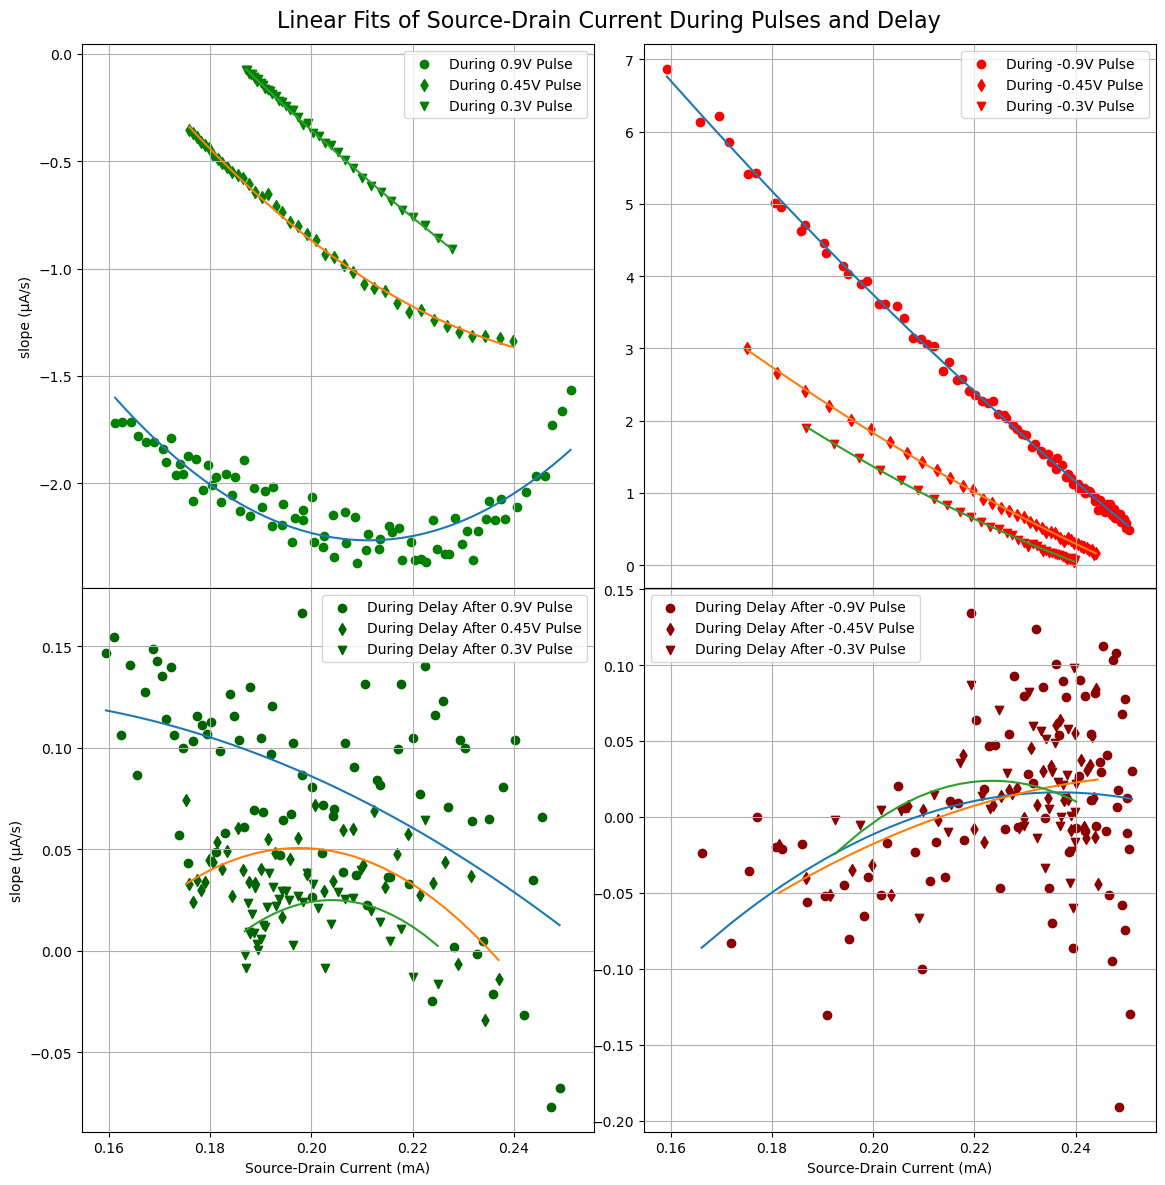

{'10.9': [np.float64(0.00011886583678895393), array([ 2.65028370e+02, -1.12005284e-01,  9.56899283e-06]), array([[ 3.41081904e+02, -1.40178683e-01,  1.41943360e-05],
       [-1.40178683e-01,  5.77947051e-05, -5.87107555e-09],
       [ 1.41943360e-05, -5.87107555e-09,  5.98452594e-13]])], '10.45': [np.float64(0.00016345491931659973), array([ 1.47735029e+02, -7.74527358e-02,  8.71291847e-06]), array([[ 7.72586669e+01, -3.17493224e-02,  3.23216994e-06],
       [-3.17493224e-02,  1.30689124e-05, -1.33258731e-09],
       [ 3.23216994e-06, -1.33258731e-09,  1.36097623e-13]])], '10.3': [np.float64(0.00018394020332966517), array([ 4.80155874e+01, -4.05292413e-02,  5.83039758e-06]), array([[ 1.11516367e+02, -4.56996700e-02,  4.66421120e-06],
       [-4.56996700e-02,  1.87407032e-05, -1.91397779e-09],
       [ 4.66421120e-06, -1.91397779e-09,  1.95598388e-13]])], '1-0.9': [np.float64(0.00026003875557833057), array([ 1.15944204e+02, -1.15700020e-01,  2.22463244e-05]), array([[ 1.91178939e+02, -8.

In [45]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from lmfit import Model

#x = np.arange(0,10)
#y = np.array([5,4.8,4.7,4.5,4.4,4.5,4.8,4.9,5,5.1])


# plot data, polyfit result, and least-squares fit
#plt.scatter(x, y, label='data')
#plt.scatter(x, function(x, a0, b0, c0), marker='+', label='polyfit')
#plt.plot(x, result.best_fit, label='least-squares fit')

# use the ModelResult to evaluate the 1-sigma and 2-sigma confidence bands
#dy1 = result.eval_uncertainty(sigma=1)

#legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   #Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=15),
                   #Patch(facecolor='orange', edgecolor='r', label='Color Patch')]

def func(x,a,b,c):
    return a*x**2+b*x+c

def min_max(popt):
    a, b, c, = popt[0], popt[1], popt[2]
    return (-b - (b**2-4*a*c)**(1/2))/(2*a)
    
def Gate_Fit(df):
    RESULTS = {}
    labels = ['positive', 'negative', 'zero-p', 'zero-n']
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*', '0.45': 'd'}

    
    
    fig, axs = plt.subplots(2,2, sharex=True, squeeze=True)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    fig.tight_layout(pad=3, h_pad=-1, w_pad=0.5)
    for index, label in enumerate(labels):
        fit_a, fit_b, x, markerstyle = Lin_Fit_2(df, label)
        fit_df = pd.DataFrame(data={'a':fit_a, 'b':fit_b, 'x':x, 'style':markerstyle})
        
        grouped = fit_df.groupby('style', sort=False)
        
        for _, group_df in grouped:
            style = group_df['style'].values[0]
            group_df = group_df.sort_values(by=['x'])
            popt, pcov = curve_fit(func,group_df['x'],group_df['a'])
            #print(pcov)
            #model = Model(func)
            #params = model.make_params(a=popt[0], b=popt[1], c=popt[2])
            #result = model.fit(group_df['a'], params, x=group_df['x'])
            
            limit = min_max(popt)
            
            
            #print(label, style)
            #print("a, b, c", popt)
            #print(result.params)
            #plt.plot(result.eval_uncertainty(sigma=1))
            #rint("STD Errors", np.sqrt(np.diag(pcov)))
            y_pred = func(group_df['x'],*popt)
            
            if style =='o':
                voltage = 0.9
            elif style =='d':
                voltage = 0.45
            else:
                voltage = 0.3
            
            if label in ['positive', 'negative']:
                pulse = 1
                if label == 'negative':
                    voltage *= -1
            else:
                pulse = 0
                if label == 'zero-n':
                    voltage *= -1
            
            RESULTS[str(pulse)+str(voltage)] = [limit, popt, pcov]

            
            axs[math.floor(index/2),index%2].scatter(group_df['x']*1000, group_df['a']*1000000, marker = style, color = colors[label])
            axs[math.floor(index/2),index%2].plot(group_df['x']*1000, y_pred*1000000, label='_nolegend_')

    for ax in axs.flat:
        ax.grid()


    
    axs[0,0].set(ylabel='slope (µA/s)')
    axs[1,0].set(xlabel='Source-Drain Current (mA)', ylabel='slope (µA/s)')
    axs[1,1].set(xlabel='Source-Drain Current (mA)')
    #axs[1,1].set(ylabel='y-label')
    #axs.label_outer()
    fig.suptitle("Linear Fits of Source-Drain Current During Pulses and Delay", fontsize=16, y=0.99)
    # Create the figure
    
    axs[0,0].legend(['During 0.9V Pulse','During 0.45V Pulse','During 0.3V Pulse'])
    axs[0,1].legend(['During -0.9V Pulse','During -0.45V Pulse','During -0.3V Pulse'])
    axs[1,0].legend(['During Delay After 0.9V Pulse','During Delay After 0.45V Pulse','During Delay After 0.3V Pulse'])
    axs[1,1].legend(['During Delay After -0.9V Pulse','During Delay After -0.45V Pulse','During Delay After -0.3V Pulse'])

    plt.savefig("Slope.pdf")
    
    plt.show()
    print(RESULTS)
df = Reset_Time(df)
Gate_Fit(df)


In [46]:
def df_Plot(df, y_range=(None,None), x_range=(None,None)):
    fig = plt.figure(figsize = (12, 12))
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 0:2])
    grouped = df.groupby(['FileNr'])
    for group_id, group_df in grouped:
        ax1.plot(group_df["Time (s)"], group_df['Gate Voltage (V)'])
        ax2.plot(group_df["Time (s)"], group_df['Gate Current (A)'])
        ax3.plot(group_df["Time (s)"], group_df['Drain Current (A)']*1000)
    fig.tight_layout(pad=2)
    ax3.set_ylim(ymin=y_range[0], ymax=y_range[1])
    ax1.set_xlim(xmin=x_range[0], xmax=x_range[1])
    ax2.set_xlim(xmin=x_range[0], xmax=x_range[1])
    ax3.set_xlim(xmin=x_range[0], xmax=x_range[1])

    ax1.grid()
    ax1.set_title("Applied Voltage Pulses")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Gate Voltage (V)")

    ax2.grid()
    ax2.set_title("Measured Current of Applied Pulses")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Gate Current (A)")

    ax3.grid()
    ax3.set_title("Measured Source-Drain Current")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Source-Drain Current (mA)")
    
    
    plt.savefig("DelayMeasurement.pdf")

def Gate_Fit(df):
    labels = ['positive', 'negative', 'zero-p', 'zero-n']
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*', '0.45': 'd'}
    
    fig, axs = plt.subplots(2,2, sharex=True, squeeze=True)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    fig.tight_layout(pad=3, h_pad=-1, w_pad=0.5)
    for index, label in enumerate(labels):
        fit_a, fit_b, x, markerstyle = Lin_Fit_2(df, label)
        fit_df = pd.DataFrame(data={'a':fit_a, 'b':fit_b, 'x':x, 'style':markerstyle})
        
        grouped = fit_df.groupby('style', sort=False)
        
        for _, group_df in grouped:
            style = group_df['style'].values[0]
            group_df = group_df.sort_values(by=['x'])
            popt, pcov = curve_fit(func,group_df['x'],group_df['a'])
            print(label, style)
            print("a, b, c", popt)
            print("STD Errors", np.sqrt(np.diag(pcov)))
            y_pred = func(group_df['x'],*popt)
            
            
            axs[math.floor(index/2),index%2].scatter(group_df['x']*1000, group_df['a']*1000000, marker = style, color = colors[label])
            axs[math.floor(index/2),index%2].plot(group_df['x']*1000, y_pred*1000000, label='_nolegend_')

    for ax in axs.flat:
        ax.grid()


    
    axs[0,0].set(ylabel='slope (µA/s)')
    axs[1,0].set(xlabel='Source-Drain Current (mA)', ylabel='slope (µA/s)')
    axs[1,1].set(xlabel='Source-Drain Current (mA)')
    #axs[1,1].set(ylabel='y-label')
    #axs.label_outer()
    fig.suptitle("Linear Fits of Source-Drain Current During Pulses and Delay", fontsize=16, y=0.99)
    # Create the figure
    
    axs[0,0].legend(['During 0.9V Pulse','During 0.45V Pulse','During 0.3V Pulse'])
    axs[0,1].legend(['During -0.9V Pulse','During -0.45V Pulse','During -0.3V Pulse'])
    axs[1,0].legend(['During Delay After 0.9V Pulse','During Delay After 0.45V Pulse','During Delay After 0.3V Pulse'])
    axs[1,1].legend(['During Delay After -0.9V Pulse','During Delay After -0.45V Pulse','During Delay After -0.3V Pulse'])

    plt.savefig("DelaySlope.pdf")
    
    plt.show()

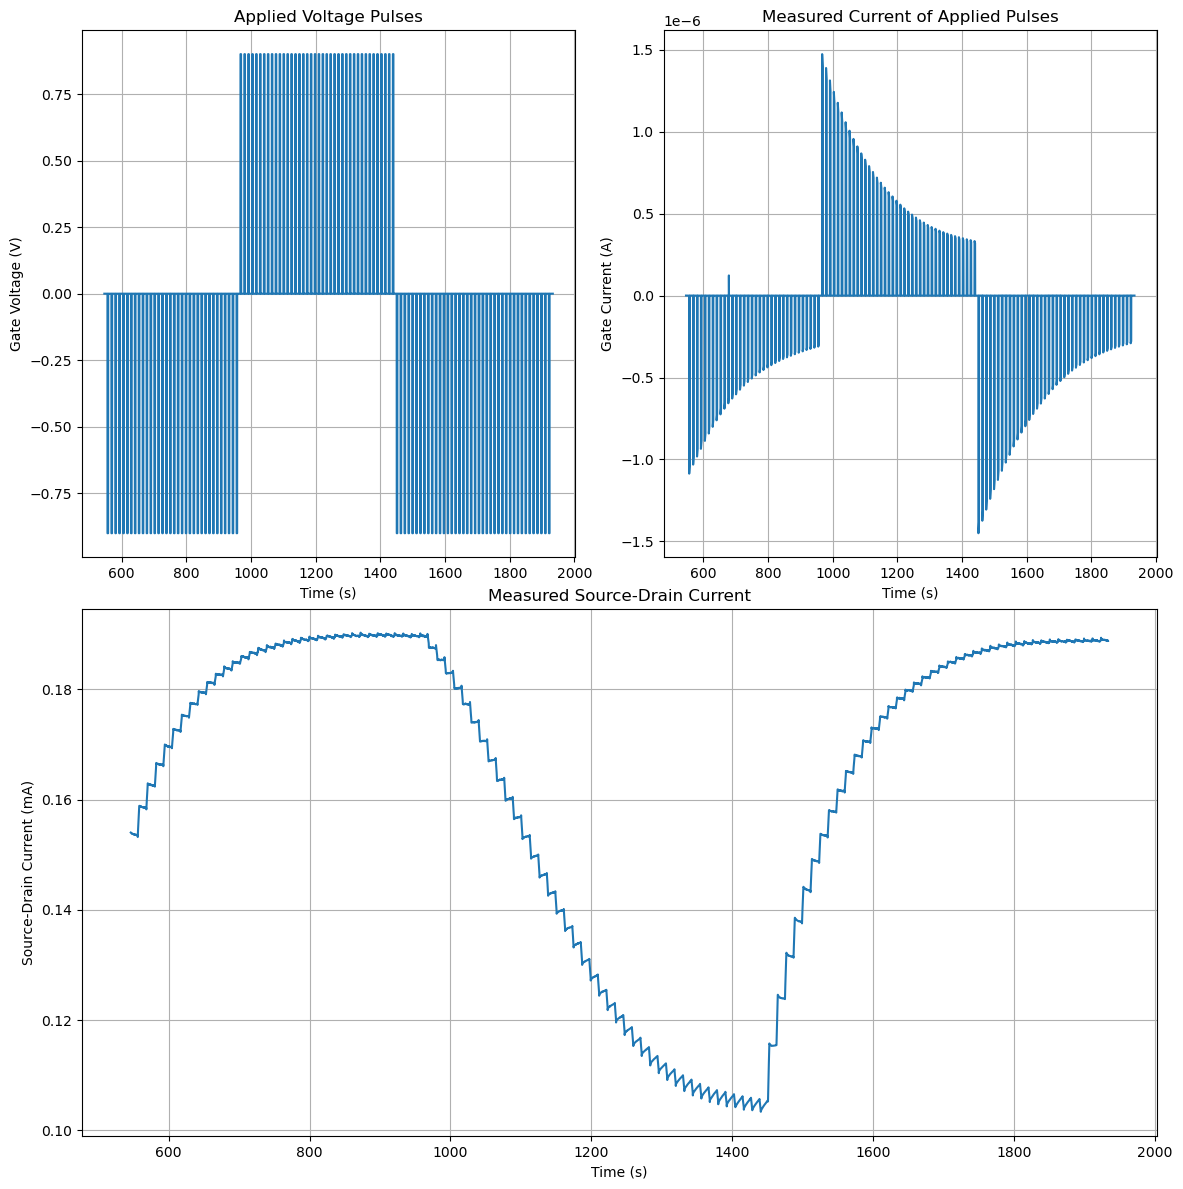

In [13]:
df = Load_Files(Test_Files_2, 1)
df = Group_Gate_Voltage(df)
df_Plot(df)
#df_Plot(df, y_range=(0.00023,0.000252), x_range=(165,200))
#df = Reset_Time(df[df['Gate Voltage (V)'] > 0.8])
#Disp_Group(df, 0)
#Plot_Group_df(df, x_range=(None, None), y_range=(0.00023,0.000252))

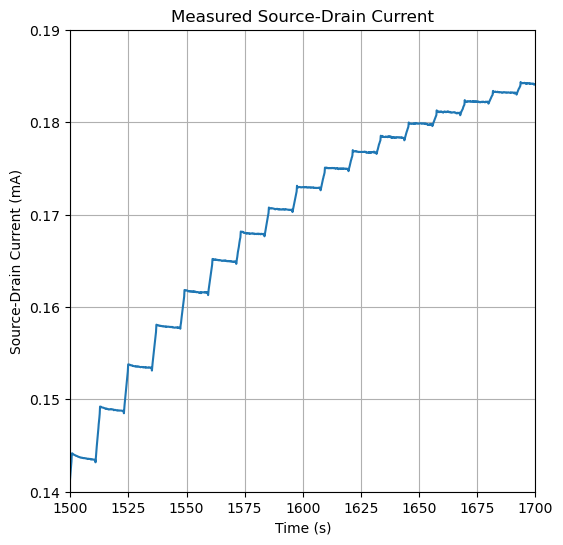

In [14]:
grouped = df.groupby(['FileNr'])
fig = plt.figure(figsize = (6, 6))
for group_id, group_df in grouped:
    
    plt.plot(group_df["Time (s)"], group_df['Drain Current (A)']*1000)
    plt.ylim(ymin=0.14, ymax=0.19)
    plt.xlim(xmin=1500, xmax=1700)
    plt.grid()
    plt.title("Measured Source-Drain Current")
    plt.xlabel("Time (s)")
    plt.ylabel("Source-Drain Current (mA)")
    plt.savefig("DelayDrainCurrentZoom.pdf")

positive o
a, b, c [ 2.34874731e+06 -5.23580070e+02 -2.64606637e-03  2.21524535e-06]
STD Errors [7.32185162e+05 3.20786823e+02 4.60074031e-02 2.15760776e-06]
negative o
a, b, c [-3.02943915e+06  1.37031512e+03 -2.63502080e-01  2.14975917e-05]
STD Errors [1.16152454e+06 5.34935897e+02 8.07867617e-02 3.99144805e-06]
zero-p o
a, b, c [-7.91794731e+05  3.70184022e+02 -5.84082655e-02  3.14431408e-06]
STD Errors [7.85428465e+04 3.38250929e+01 4.76625502e-03 2.19491667e-07]
zero-n o
a, b, c [-1.38185031e+06  6.48419935e+02 -9.96733114e-02  4.97663690e-06]
STD Errors [1.21699452e+05 5.77817324e+01 9.03559630e-03 4.64700750e-07]


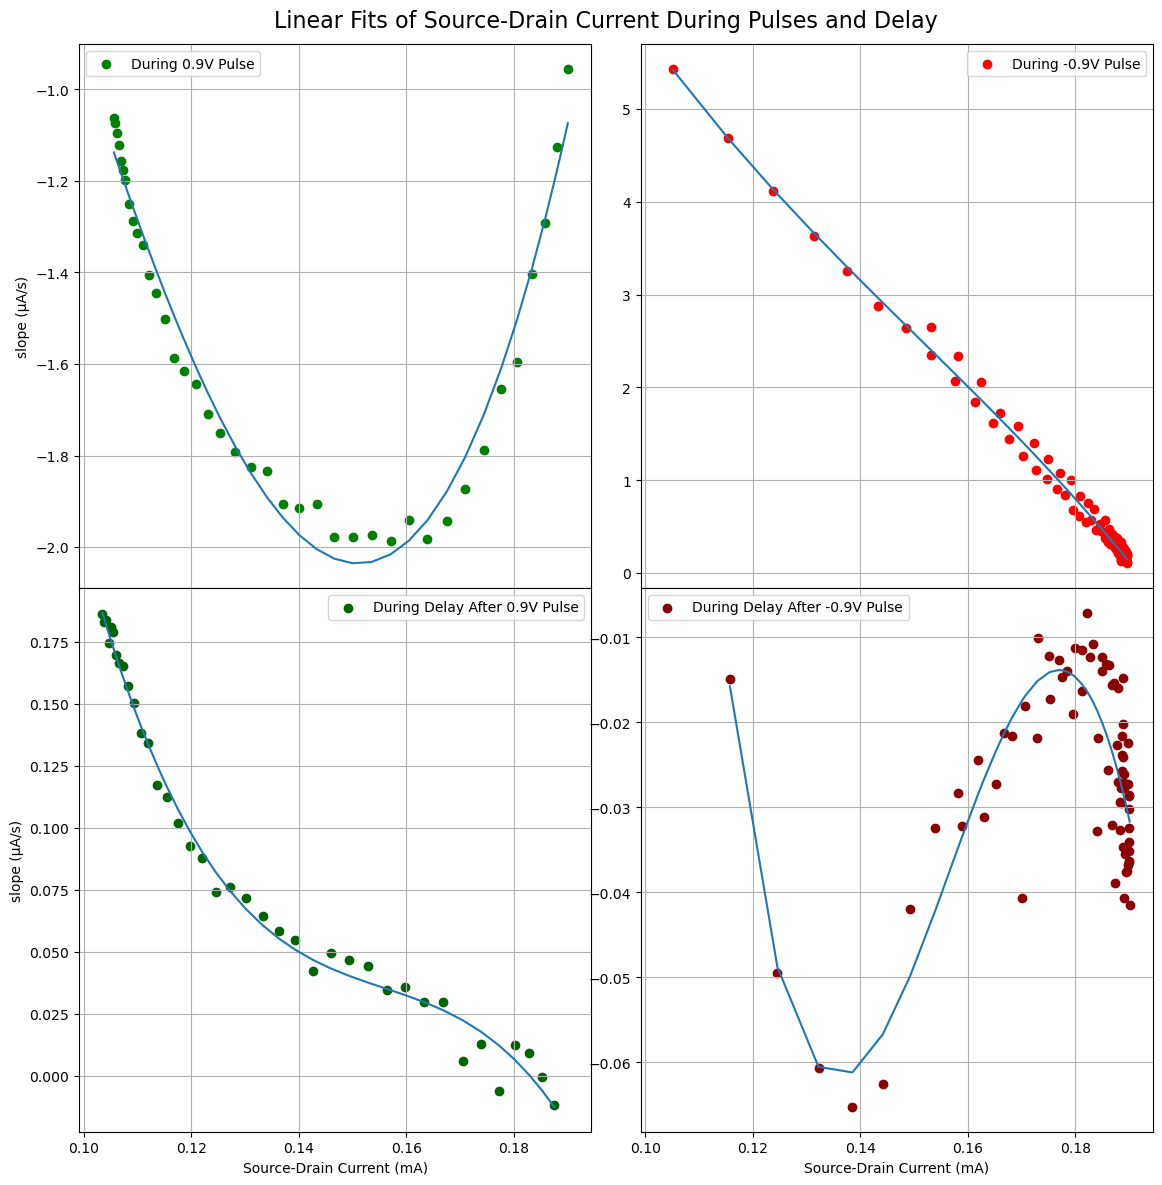

In [15]:
df = Reset_Time(df)
#def func(x,a,b,c):
#    return a*x**2+b*x+c
def func(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d
Gate_Fit(df)


In [136]:
results = {'10.9': [np.float64(0.00011886583678895393), np.array([ 2.65028370e+02, -1.12005284e-01,  9.56899283e-06]), np.array([[ 3.41081904e+02, -1.40178683e-01,  1.41943360e-05],
       [-1.40178683e-01,  5.77947051e-05, -5.87107555e-09],
       [ 1.41943360e-05, -5.87107555e-09,  5.98452594e-13]])], '10.45': [np.float64(0.00016345491931659973), np.array([ 1.47735029e+02, -7.74527358e-02,  8.71291847e-06]), np.array([[ 7.72586669e+01, -3.17493224e-02,  3.23216994e-06],
       [-3.17493224e-02,  1.30689124e-05, -1.33258731e-09],
       [ 3.23216994e-06, -1.33258731e-09,  1.36097623e-13]])], '10.3': [np.float64(0.00018394020332966517), np.array([ 4.80155874e+01, -4.05292413e-02,  5.83039758e-06]), np.array([[ 1.11516367e+02, -4.56996700e-02,  4.66421120e-06],
       [-4.56996700e-02,  1.87407032e-05, -1.91397779e-09],
       [ 4.66421120e-06, -1.91397779e-09,  1.95598388e-13]])], '1-0.9': [np.float64(0.00026003875557833057), np.array([ 1.15944204e+02, -1.15700020e-01,  2.22463244e-05]), np.array([[ 1.91178939e+02, -8.12585681e-02,  8.49919839e-06],
       [-8.12585681e-02,  3.46429721e-05, -3.63588463e-09],
       [ 8.49919839e-06, -3.63588463e-09,  3.83126191e-13]])], '1-0.45': [np.float64(0.0002492345648416061), np.array([ 1.22287678e+02, -9.21124970e-02,  1.53613682e-05]), np.array([[ 7.97182020e+01, -3.42316063e-02,  3.63838503e-06],
       [-3.42316063e-02,  1.47264642e-05, -1.56844986e-09],
       [ 3.63838503e-06, -1.56844986e-09,  1.67438006e-13]])], '1-0.3': [np.float64(0.00024176044228483494), np.array([ 1.62371063e+02, -1.04453074e-01,  1.57623395e-05]), np.array([[ 2.05092633e+02, -8.93237071e-02,  9.66763423e-06],
       [-8.93237071e-02,  3.89452088e-05, -4.22010123e-09],
       [ 9.66763423e-06, -4.22010123e-09,  4.57891652e-13]])], '00.9': [np.float64(0.0002555617843892662), np.array([-7.78162567e+00,  1.99715409e-03, -2.16408543e-09]), np.array([[ 6.50773033e+01, -2.64767143e-02,  2.65389768e-06],
       [-2.64767143e-02,  1.08069748e-05, -1.08677951e-09],
       [ 2.65389768e-06, -1.08677951e-09,  1.09668314e-13]])], '00.45': [np.float64(0.00023529982087532397), np.array([-3.55743010e+01,  1.40563603e-02, -1.33785212e-06]), np.array([[ 8.13358446e+01, -3.31383239e-02,  3.34628985e-06],
       [-3.31383239e-02,  1.35227011e-05, -1.36760309e-09],
       [ 3.34628985e-06, -1.36760309e-09,  1.38522597e-13]])], '00.3': [np.float64(0.00022605881252930259), np.array([-5.15965675e+01,  2.10562616e-02, -2.12323543e-06]), np.array([[ 5.09530141e+02, -2.07419577e-01,  2.10381076e-05],
       [-2.07419577e-01,  8.44879749e-05, -8.57445489e-09],
       [ 2.10381076e-05, -8.57445489e-09,  8.70693674e-13]])], '0-0.9': [np.float64(0.00026470970595861255), np.array([-2.05803167e+01,  9.73904812e-03, -1.13593249e-06]), np.array([[ 1.86982629e+02, -8.06491110e-02,  8.58040479e-06],
       [-8.06491110e-02,  3.48748597e-05, -3.72104187e-09],
       [ 8.58040479e-06, -3.72104187e-09,  3.98334608e-13]])], '0-0.45': [np.float64(0.00030845311348857936), np.array([-1.23612393e+01,  6.44789895e-03, -8.12785123e-07]), np.array([[ 2.07161987e+02, -9.01196298e-02,  9.72153183e-06],
       [-9.01196298e-02,  3.92629500e-05, -4.24244813e-09],
       [ 9.72153183e-06, -4.24244813e-09,  4.59254225e-13]])], '0-0.3': [np.float64(0.00024537588997422825), np.array([-4.98502333e+01,  2.22827221e-02, -2.46619375e-06]), np.array([[ 1.27760377e+03, -5.62721409e-01,  6.16733933e-05],
       [-5.62721409e-01,  2.48062197e-04, -2.72122967e-08],
       [ 6.16733933e-05, -2.72122967e-08,  2.98818147e-12]])]}

def rand_conversion(x, popt, std):
    slope = popt[0]*x**2+popt[1]*x+popt[2]
    return np.random.normal(loc=slope, scale=std)

def min_max(popt, voltage):
    a, b, c, = popt[0], popt[1], popt[2]
    return (-b - (b**2-4*a*c)**(1/2))/(2*a)

# Starting variables
OPERATING_VOLTAGE = 0.9 #+- is decided later
pulse = 1 # 0 for delay
minimum, popt, pcov = results[str(pulse)+str(OPERATING_VOLTAGE)]
maximum, popt, pcov = results[str(pulse)+str(-1*OPERATING_VOLTAGE)]
width = (maximum-minimum)/2

#Iteration Variables
WEIGHT = 0
curr = minimum + width + WEIGHT*width

BACKPROPAGATION_RESULT = 1 #Change due to backpropogation, if >0 we use negative, if <0 we use positive
voltage = -1*OPERATING_VOLTAGE*BACKPROPAGATION_RESULT/abs(BACKPROPAGATION_RESULT)
limit, popt, pcov = results[str(pulse)+str(voltage)]
pcov = pcov.copy()

for i in range(3):
    pcov[i] = pcov[i]*curr**(2-i)
for j in range(3):
    pcov[:, j] = pcov[:, j]*curr**(2-j)
std = sum(sum(pcov))**(1/2)

slope = rand_conversion(curr, popt, std)
slope_weight = slope/width
print(slope_weight*abs(BACKPROPAGATION_RESULT)) #Multiply slope_weight with abs(backpropogation result) and learning rate and update the weight with the change
    

0.06382667532308965
